## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
from IPython.display import display, Markdown, clear_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70360,00017338_000.png,No Finding,0,17338,51,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017338_000.png
99811,00026441_000.png,Infiltration,0,26441,30,F,PA,2544,3056,0.139,0.139,NaN,/data/images_011/images/00026441_000.png
97695,00025787_018.png,Infiltration,18,25787,27,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00025787_018.png


In [3]:
# Split the labels into a list
if isinstance(all_xray_df['Finding Labels'].values[0], str):
    all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].str.split('|')
    
# grep all the labels
FINDING_LABELS = pd.Series(np.concatenate(all_xray_df['Finding Labels']).ravel())

for fn in FINDING_LABELS.value_counts().index:
    all_xray_df[fn] = [1 if fn in v else 0 for v in all_xray_df['Finding Labels']]
    
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
31437,00008220_001.png,[No Finding],1,8220,45,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008220_001.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51241,00012940_000.png,[Infiltration],0,12940,23,M,PA,2854,2991,0.143,0.143,NaN,/data/images_006/images/00012940_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
74694,00018342_000.png,[No Finding],0,18342,39,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00018342_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'] == 1
all_xray_df['pneumonia_class_str'] = all_xray_df['pneumonia_class'].astype(str)

all_xray_df[all_xray_df['pneumonia_class'] == True].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia,pneumonia_class,pneumonia_class_str
99311,00026263_010.png,"[Atelectasis, Consolidation, Effusion, Pneumonia]",10,26263,38,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026263_010.png,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,True,True
62915,00015556_023.png,"[Effusion, Pneumonia]",23,15556,56,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00015556_023.png,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,True,True
8648,00002288_004.png,[Pneumonia],4,2288,61,M,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00002288_004.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,True,True


## Create your training and testing data:

In [5]:
def create_splits(df, test_size, stratify):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df,  test_size = test_size, stratify = df[stratify])
    
    #
    # balance the training data:
    #
    # shuffle the dataset & sort on 'pneumonia_class'
    train_data = train_data.sample(len(train_data))\
                           .sort_values('pneumonia_class', ascending=False)
    
    # take  the first 2 x len('pneumonia_class' == True) 
    train_data = train_data.iloc[:train_data.pneumonia_class.sum() * 2, :]
    
    # shuffle train data
    train_data = train_data.sample(train_data.shape[0])
    
    
    #
    # Reduce the size of the negative pneumonia cases in the validation set, the current ratio is 1 on 100
    #
    # shuffle the data and sort by pneumonia_class
    val_data = val_data.sample(len(val_data))\
                       .sort_values('pneumonia_class', ascending=False)
    
    
    # take  the first 4 x len('pneumonia_class' == True)  
    # --> therefore the ratio will become 25%
    val_data = val_data.iloc[:val_data.pneumonia_class.sum() * 4, :]
    
    # shuffle train data
    val_data = val_data.sample(val_data.shape[0])
    
    return train_data, val_data

df_train, df_val = create_splits(all_xray_df, 0.2, 'pneumonia_class')


display(Markdown('<b>Distribution Training-set</b> '))
display(Markdown(f'<i>Size</i>: {len(df_train)} '))
display(df_train.pneumonia_class.value_counts()/len(df_train)*100)

display(Markdown('<b>Distribution Validation-set</b> '))
display(Markdown(f'<i>Size</i>: {len(df_val)} '))
display(df_val.pneumonia_class.value_counts()/len(df_val)*100)

<b>Distribution Training-set</b> 

<i>Size</i>: 2290 

True     50.0
False    50.0
Name: pneumonia_class, dtype: float64

<b>Distribution Validation-set</b> 

<i>Size</i>: 1144 

False    75.0
True     25.0
Name: pneumonia_class, dtype: float64

# Now we can begin our model-building & training

In [6]:
# Hyper parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation(training = True):
    
    if training:
        return tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1. / 255.0,
                                           horizontal_flip = True, 
                                           vertical_flip = False, 
                                           height_shift_range= 0.1, 
                                           width_shift_range=0.1, 
                                           rotation_range=20, 
                                           shear_range = 0.1,
                                           zoom_range=0.1)
    else:
        return tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1. / 255.0)

In [8]:
def make_train_gen(df, idg):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    return idg.flow_from_dataframe(dataframe=df, 
                                   directory=None, 
                                   x_col = 'path',
                                   y_col = 'pneumonia_class_str',
                                   class_mode = 'binary',
                                   shuffle = True,
                                   target_size = IMG_SIZE, 
                                   batch_size = BATCH_SIZE)


def make_val_gen(df, idg):
    
    return idg.flow_from_dataframe(dataframe=df, 
                                       directory=None, 
                                       x_col = 'path',
                                       y_col = 'pneumonia_class_str',
                                       class_mode = 'binary',
                                       shuffle = False,
                                       target_size = IMG_SIZE, 
                                       batch_size = BATCH_SIZE)

In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(df_val, my_image_augmentation(training=False))
valX, valY = val_gen.next()

Found 1144 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


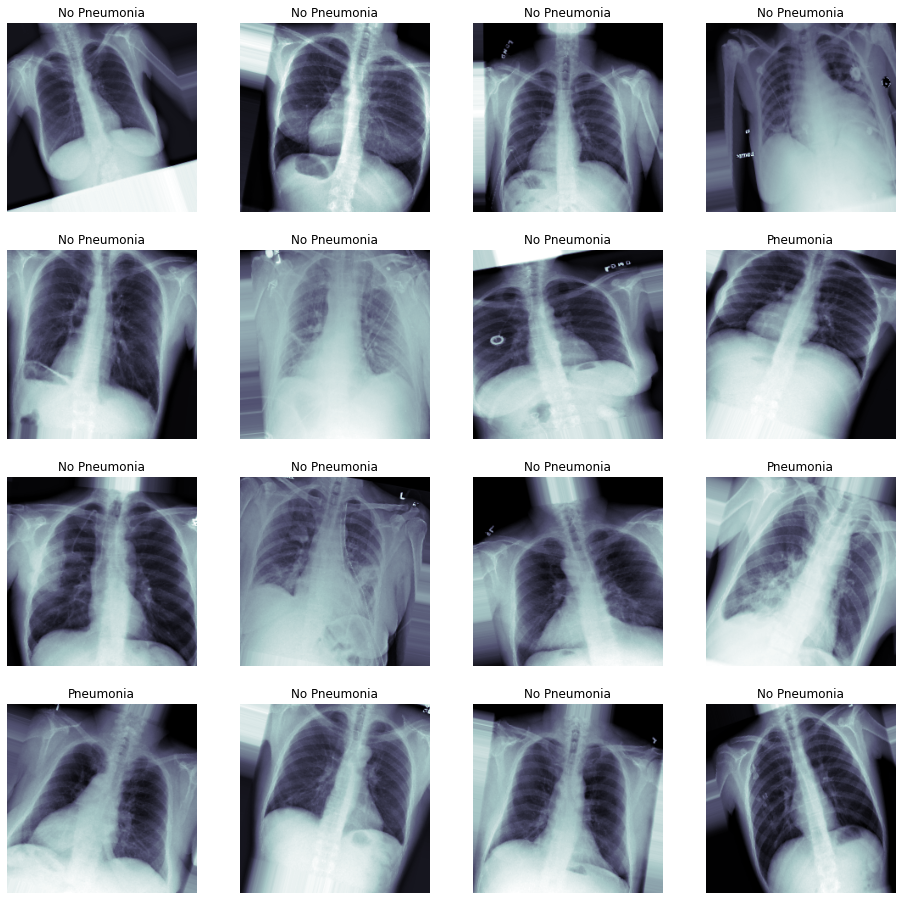

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen(df_train, my_image_augmentation())


t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model(lay_of_interest = 'block5_pool'):
    
    model = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
    
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = tf.keras.models.Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    return vgg_model


In [12]:
def build_my_model():
    
    
    model = tf.keras.models.Sequential()

    # add your pre-trained model, 
    model.add(load_pretrained_model())

    # additional layers   
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [13]:
my_model = build_my_model()
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path = "{}_my_model.best.hdf5".format('xray_class')

checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path, 
                                                monitor= 'val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode= 'auto', 
                                                save_weights_only = True)

early = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', 
                                         mode= 'auto', 
                                         patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

# set the model
optimizer = tf.keras.optimizers.Adam(lr=0.0003)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = ['accuracy']

# compile
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
# train
history = my_model.fit( train_gen, 
                        validation_data = (valX, valY), 
                        epochs = 50, 
                        callbacks = callbacks_list)

  ...
    to  
  ['...']
Train for 36 steps, validate on 64 samples
Epoch 1/50
35/36 [============================>.] - ETA: 1s - loss: 0.7768 - accuracy: 0.5135
Epoch 00001: val_loss improved from inf to 0.63290, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 63s 2s/step - loss: 0.7750 - accuracy: 0.5140 - val_loss: 0.6329 - val_accuracy: 0.6562
Epoch 2/50
35/36 [============================>.] - ETA: 1s - loss: 0.6847 - accuracy: 0.5588
Epoch 00002: val_loss improved from 0.63290 to 0.62794, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 59s 2s/step - loss: 0.6858 - accuracy: 0.5590 - val_loss: 0.6279 - val_accuracy: 0.6250
Epoch 3/50
35/36 [============================>.] - ETA: 1s - loss: 0.6767 - accuracy: 0.5818
Epoch 00003: val_loss improved from 0.62794 to 0.62722, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 58s 2s/step - loss: 0.6774 - accuracy: 0.5812 - v

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

pred_Y = my_model.predict(val_gen, verbose = True)
val_Y = df_val['Pneumonia']

18/18 [==============================] - 23s 1s/step


In [18]:
# ROC Curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = f'Pneumonia (AUC:{np.around(auc(fpr, tpr), 3)})')
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# Recall Curve
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = f'Pneumonia (AP Score: {np.around(aps,2)})')
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

# Progress
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("model Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("model Accuracy")

    plt.show()

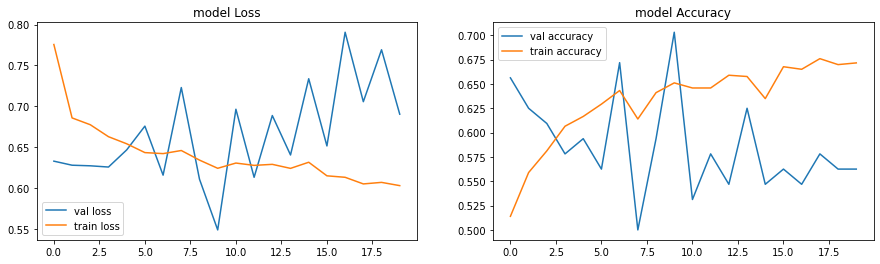

In [19]:
plot_history(history)

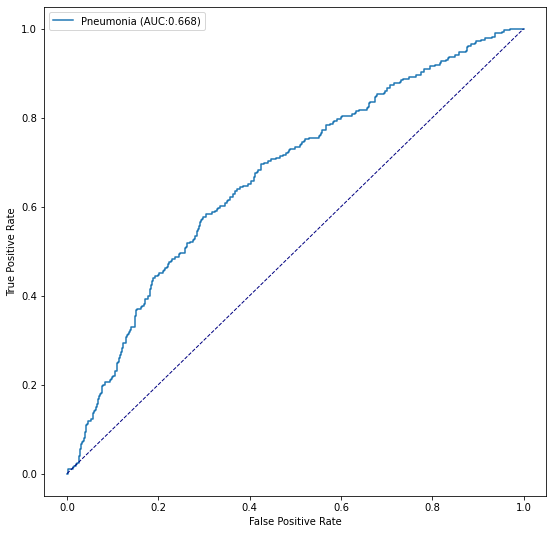

In [20]:
plot_auc(val_Y, pred_Y)

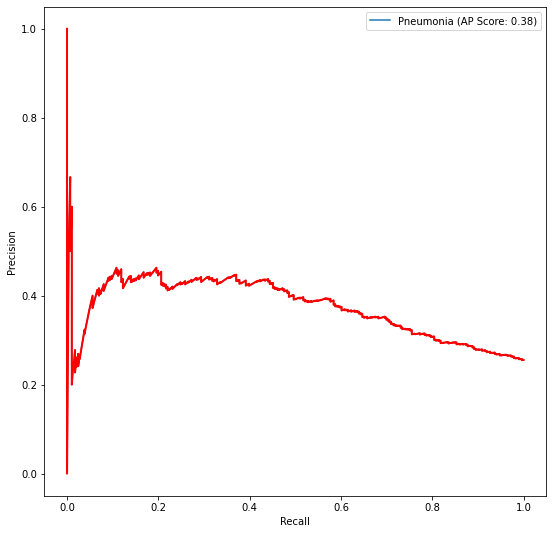

In [21]:
plot_precision_recall_curve_helper(val_Y, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Precision: 0.3528368794326241
Recall: 0.6958041958041958
Threshold: 0.3741466
F1 Score: 0.4682352941176471


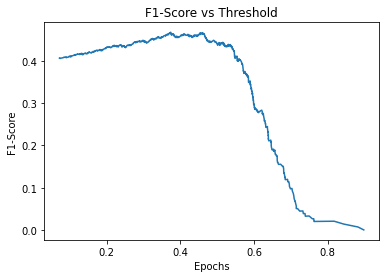

In [22]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

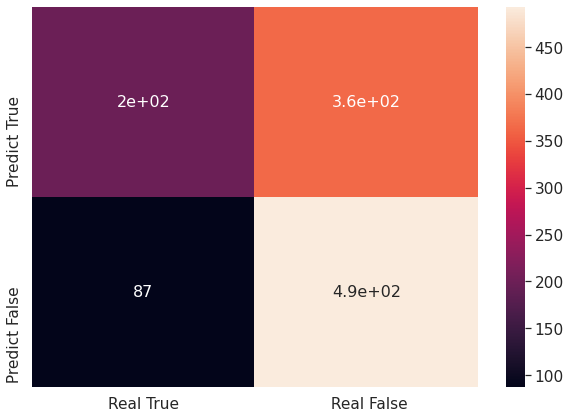

In [23]:
tn, fp, fn, tp = confusion_matrix(y_true= val_Y,
                                  y_pred= pred_Y.ravel() >= thresholds[idx]).ravel()


table = pd.DataFrame((np.array([[tp,fp],[fn,tn]]).astype(int)), 
             columns=['Real True',' Real False'], 
             index=['Predict True',' Predict False'] )

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(table, 
           annot=True, 
           annot_kws={"size": 16}); # font size


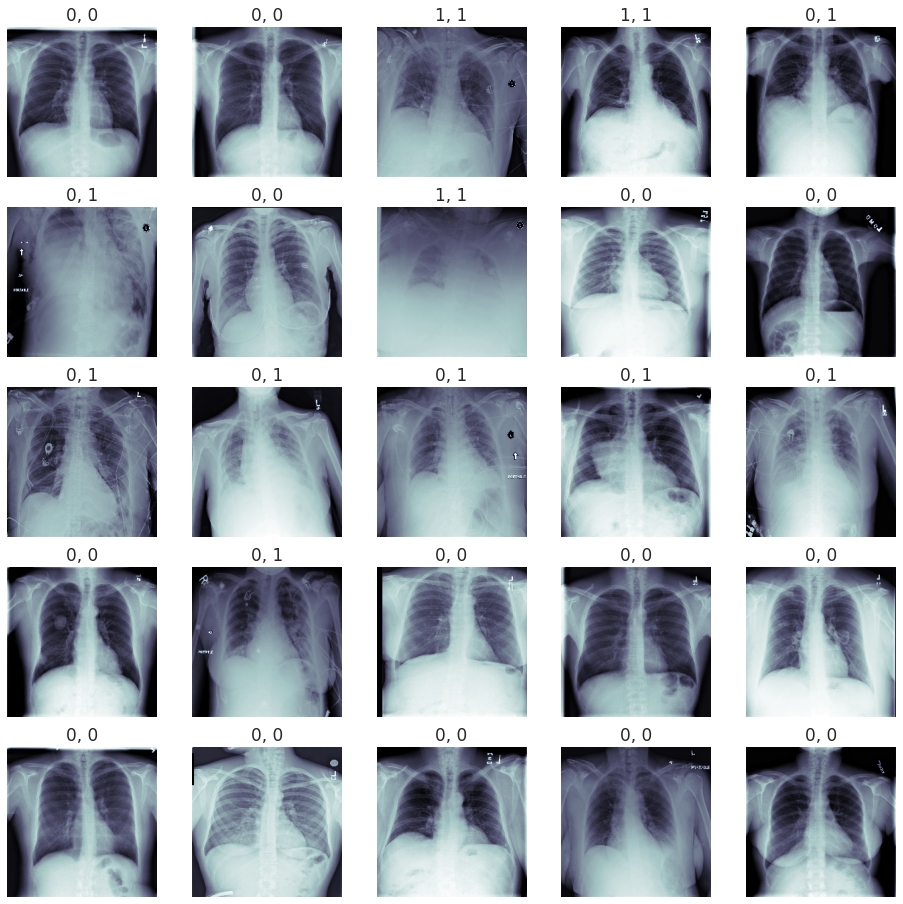

In [24]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [30]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [31]:
# the above json file doesn't work well,  while loading the data
my_model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets
